In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [62]:
df = pd.read_csv("../Paitients_Files_Train.csv",delimiter=",").drop(columns=["ID","Insurance"])
df.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,Positive
1,1,85,66,29,0,26.6,0.351,31,Negative
2,8,183,64,0,0,23.3,0.672,32,Positive
3,1,89,66,23,94,28.1,0.167,21,Negative
4,0,137,40,35,168,43.1,2.288,33,Positive


In [63]:
df["Sepssis"] = np.where(df["Sepssis"].str.contains("Positive"), 1, 0)

# Feature Engineering

In [64]:
df

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
594,6,123,72,45,230,33.6,0.733,34,0
595,0,188,82,14,185,32.0,0.682,22,1
596,0,67,76,0,0,45.3,0.194,46,0
597,1,89,24,19,25,27.8,0.559,21,0


In [65]:
df[df.duplicated()]

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis


## Clean BMI values: weird 0, and binning

In [66]:
from sklearn.impute import KNNImputer
from math import sqrt
from sklearn.compose import ColumnTransformer

df["M11"].replace({0:np.nan}, inplace=True)

no_neighbors = int(sqrt(len(df)))
imputer = KNNImputer(n_neighbors=no_neighbors)


X_imput = imputer.fit_transform(df)
column_names = ["BGlucose","B1","BPressure", "B2", "B3", "BMI","B4", "Age", "Sepsis"]
df = pd.DataFrame(X_imput, columns= column_names)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BGlucose   599 non-null    float64
 1   B1         599 non-null    float64
 2   BPressure  599 non-null    float64
 3   B2         599 non-null    float64
 4   B3         599 non-null    float64
 5   BMI        599 non-null    float64
 6   B4         599 non-null    float64
 7   Age        599 non-null    float64
 8   Sepsis     599 non-null    float64
dtypes: float64(9)
memory usage: 42.2 KB


In [68]:
#Creating bins and labels
bins = [1,18.5,25.0,30.0,100]
labels = [1,2,3,4]

df['BMI'] = pd.cut(df['BMI'],bins = bins, labels = labels)
df.BMI.value_counts()

4    367
3    144
2     84
1      4
Name: BMI, dtype: int64

## Clean Age: binning

In [35]:
#Creating bins and labels
bins = [1,19,30,50,100]
labels = [1,2,3,4]

df['Age'] = pd.cut(df['Age'],bins = bins, labels = labels)
df.Age.value_counts()

2    323
3    209
4     67
1      0
Name: Age, dtype: int64

# Chi-square test

In [36]:
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

X_chi = df.drop(columns="Sepsis")
Y = df[["Sepsis"]]
imputer = SimpleImputer(strategy="median")
X_chi = imputer.fit_transform(X_chi)

chis = chi2(X_chi, Y)

len(column_names)
chis[0].reshape(len(column_names)-1,1)

chi_dict = {}
p_dict = {}
for i in range(len(column_names)-1):
    chi_dict[column_names[i]] = chis[0][i]
    p_dict[column_names[i]] = chis[1][i]

In [37]:
p_dict

{'BGlucose': 3.0653427633619102e-18,
 'B1': 8.26169197335336e-236,
 'BPressure': 0.0004940613252836382,
 'B2': 6.621416488443324e-11,
 'B3': 0.0,
 'BMI': 0.0009681675840254796,
 'B4': 0.030732554868312577,
 'Age': 0.014062406490152684}

# Models

In [38]:
Y = df[["Sepsis"]].to_numpy().ravel()
X = df.drop(columns=["Sepsis"])

In [39]:
df

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age,Sepsis
0,6.0,148.0,72.0,35.0,0.0,4,0.627,3,1.0
1,1.0,85.0,66.0,29.0,0.0,3,0.351,3,0.0
2,8.0,183.0,64.0,0.0,0.0,2,0.672,3,1.0
3,1.0,89.0,66.0,23.0,94.0,3,0.167,2,0.0
4,0.0,137.0,40.0,35.0,168.0,4,2.288,3,1.0
...,...,...,...,...,...,...,...,...,...
594,6.0,123.0,72.0,45.0,230.0,4,0.733,3,0.0
595,0.0,188.0,82.0,14.0,185.0,4,0.682,2,1.0
596,0.0,67.0,76.0,0.0,0.0,4,0.194,3,0.0
597,1.0,89.0,24.0,19.0,25.0,3,0.559,2,0.0


In [40]:
result_dict_train = {}

# KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()

train_score = cross_val_score(knn, X, Y, cv=10, scoring="f1_micro")

print("Train Score: %.3f" % np.mean(train_score))


Train Score: 0.690


In [50]:
from sklearn.model_selection import GridSearchCV
grid = {'n_neighbors':np.arange(1,120),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

knn = KNeighborsClassifier(algorithm = "auto")
knn_cv = GridSearchCV(knn,grid,cv=10, scoring="f1_micro")
knn_cv.fit(X,Y)

print("Hyperparameters:",knn_cv.best_params_)
print("Train Score:",knn_cv.best_score_)

Hyperparameters: {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
Train Score: 0.7430225988700566


In [43]:
result_dict_train["KNN Default settings"] = np.mean(train_score)
result_dict_train["KNN GridSearch Train Score"] = knn_cv.best_score_
result_dict_train

{'KNN Default settings': 0.6895762711864407,
 'KNN GridSearch Train Score': 0.7430225988700565}

# Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=4)
train_score = cross_val_score(rfc, X, Y, cv=10, scoring="f1_micro")
print("Train Score:",np.mean(train_score))

Train Score: 0.7629943502824859


In [46]:
grid = {'n_estimators':np.arange(50,1000,100),
       }

rf = RandomForestClassifier(random_state = 4, max_features="sqrt", class_weight="balanced")
rf_cv = GridSearchCV(rf,grid,cv=10, scoring="f1_micro")
rf_cv.fit(X,Y)

print("Hyperparameters:",rf_cv.best_params_)
print("Train Score:",rf_cv.best_score_)

Hyperparameters: {'n_estimators': 50}
Train Score: 0.7663559322033898


In [48]:
result_dict_train["Random Forest Default"] = np.mean(train_score)
result_dict_train["Random Forest GridSearch Train Score"] = rf_cv.best_score_
result_dict_train

{'KNN Default settings': 0.6895762711864407,
 'KNN GridSearch Train Score': 0.7430225988700565,
 'Random Forest Default': 0.7629943502824859,
 'Random Forest GridSearch Train Score': 0.7663559322033898}

# SVM

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svc = SVC(random_state = 42)
accuracies = cross_val_score(svc, X, Y, cv=10, scoring="f1_micro")
# svc.fit(x_train,y_train)

print("Train Score:",np.mean(accuracies))

Train Score: 0.7345762711864406


In [84]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
scaler = RobustScaler()
svm  = SVC()

svm_pipe = Pipeline(steps=[
                            ("scaler",scaler),
                            ("svm",svm)])
grid = {
    'svm__C':[0.01,0.1,1,10],
    'svm__kernel' : ["linear","poly","sigmoid","rbf"],
    'svm__degree' : [1,3,5,7],
    'svm__gamma' : [0.01,1]
}

svm_cv = GridSearchCV(svm_pipe, grid, cv = 5, scoring="f1_micro")
svm_cv.fit(X,Y)
svm_cv_std = svm_cv.cv_results_['std_test_score']


In [85]:
print("Best: %f using %s" % (svm_cv.best_score_, svm_cv.best_params_))

Best: 0.771359 using {'svm__C': 10, 'svm__degree': 1, 'svm__gamma': 0.01, 'svm__kernel': 'linear'}


In [86]:
means = svm_cv.cv_results_['mean_test_score']
stds = svm_cv.cv_results_['std_test_score']
params = svm_cv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.749622 (0.025462) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 0.01, 'svm__kernel': 'linear'}
0.652759 (0.003499) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 0.01, 'svm__kernel': 'poly'}
0.652759 (0.003499) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 0.01, 'svm__kernel': 'sigmoid'}
0.652759 (0.003499) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
0.749622 (0.025462) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
0.749622 (0.025462) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 1, 'svm__kernel': 'poly'}
0.652759 (0.003499) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 1, 'svm__kernel': 'sigmoid'}
0.652759 (0.003499) with: {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
0.749622 (0.025462) with: {'svm__C': 0.01, 'svm__degree': 3, 'svm__gamma': 0.01, 'svm__kernel': 'linear'}
0.652759 (0.003499) with: {'svm__C': 0.01, 'svm__degree': 3, 'svm_

In [87]:
result_dict_train["SVM Default"] = np.mean(train_score)
result_dict_train["SVM GridSearch Train Score"] = svm_cv.best_score_
result_dict_train

{'KNN Default settings': 0.6895762711864407,
 'KNN GridSearch Train Score': 0.7430225988700565,
 'Random Forest Default': 0.7629943502824859,
 'Random Forest GridSearch Train Score': 0.7680225988700565,
 'SVM Default': 0.7629943502824859,
 'SVM GridSearch Train Score': 0.771358543417367}

# AdaBoost

In [52]:
from sklearn.ensemble import AdaBoostClassifier
adbc = AdaBoostClassifier(random_state=4)
score = cross_val_score(adbc, X, Y,scoring="f1_micro", cv=10)
print(np.mean(score))

0.7646610169491525


In [53]:
grid = {}
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
# define the grid search procedure
grid_search = GridSearchCV(estimator=adbc, param_grid=grid, n_jobs=-1, cv=10, scoring='f1_micro')
# execute the grid search
grid_result = grid_search.fit(X, Y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.772994 using {'learning_rate': 0.01, 'n_estimators': 500}


In [90]:
result_dict_train["AdaBoost Default"] = np.mean(score)
result_dict_train["AdaBoost GridSearch"] = grid_result.best_score_
result_dict_train

{'KNN Default settings': 0.6895762711864407,
 'KNN GridSearch Train Score': 0.7430225988700565,
 'Random Forest Default': 0.7629943502824859,
 'Random Forest GridSearch Train Score': 0.7680225988700565,
 'SVM Default': 0.7629943502824859,
 'SVM GridSearch Train Score': 0.771358543417367,
 'AdaBoost Default': 0.7646610169491525,
 'AdaBoost GridSearch': 0.7729943502824858}

# Logistic Regression

In [54]:
# use polynomial to improve model fitting
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
poly = PolynomialFeatures(degree=1)

# instantiate the model (using the default parameters)
solver = "saga"
lr_model = LogisticRegression(solver= solver, 
max_iter=7000, tol=1e-3,
random_state=4)

scaler = RobustScaler()

lr_pipe = Pipeline(steps=[("poly",poly),
                            ("scaler",scaler),
                            ("logistic",lr_model)])
lr_score = cross_val_score(lr_pipe,X,Y,scoring="f1_micro",cv=10)
print("Logistic Regression default: %.3f"%np.mean(lr_score))

Logistic Regression default: 0.773


In [57]:
# SearchGrid CV
from sklearn.model_selection import GridSearchCV, RepeatedKFold
param_grid = {
    "logistic__C":np.logspace(-3, 10, 10),
    "logistic__penalty":["l2","l1"],
    "poly__degree":[1,2,3,4]

}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=4)
search = GridSearchCV(lr_pipe, param_grid, scoring="f1_micro",cv=10)
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.785):
{'logistic__C': 0.027825594022071243, 'logistic__penalty': 'l1', 'poly__degree': 3}


In [58]:
result_dict_train["Logistic Regression Default"] = np.mean(lr_score)
result_dict_train["Logistic Regression GridSearch"] = search.best_score_
result_dict_train

{'KNN Default settings': 0.6895762711864407,
 'KNN GridSearch Train Score': 0.7430225988700565,
 'Random Forest Default': 0.7629943502824859,
 'Random Forest GridSearch Train Score': 0.7663559322033898,
 'Logistic Regression Default': 0.7730508474576272,
 'Logistic Regression GridSearch': 0.7847175141242937}

# Comparison

In [59]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index",columns=["Score"])
df_result_train

,Score
KNN Default settings,0.689576
KNN GridSearch Train Score,0.743023
Random Forest Default,0.762994
Random Forest GridSearch Train Score,0.766356
Logistic Regression Default,0.773051
Logistic Regression GridSearch,0.784718


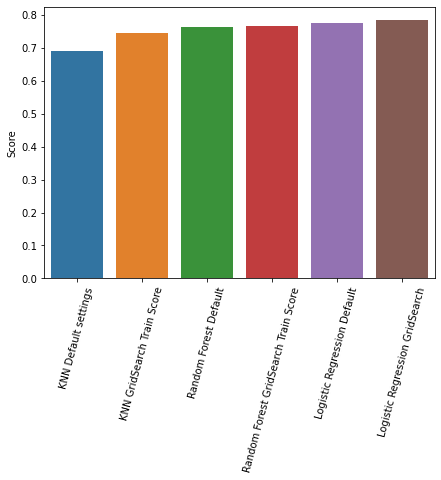

In [60]:
# fig,ax = plt.subplots(1,2,figsize=(20,5))
import seaborn as sns
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score)
ax.set_xticklabels(df_result_train.index,rotation = 75)
plt.show()

# Testing

In [20]:
patients_df_test = pd.read_csv("../Paitients_Files_Test.csv").drop(columns=["ID","Insurance"])
patients_df_test.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,1,109,38,18,120,23.1,0.407,26
1,1,108,88,19,0,27.1,0.400,24
2,6,96,0,0,0,23.7,0.190,28
3,1,124,74,36,0,27.8,0.100,30
4,7,150,78,29,126,35.2,0.692,54


In [21]:
column_names = {
    "PRG": "BGlucose",
    "PR": "BPressure",
    "PL": "B1",
    "SK": "B2",
    "TS": "B3",
    "BD2": "B4",
    "M11": "BMI"
}
patients_df_test = patients_df_test.rename(columns= column_names)

In [22]:
patients_df_test.isna().sum()

BGlucose     0
B1           0
BPressure    0
B2           0
B3           0
BMI          0
B4           0
Age          0
dtype: int64

In [23]:
patients_df_test.describe()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.917160,123.520710,70.426036,20.443787,81.000000,32.249704,0.438876,33.065089
std,3.402415,29.259123,19.426805,15.764962,110.720852,7.444886,0.306935,11.548110
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.600000,0.223000,24.000000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.343000,28.000000
75%,6.000000,141.000000,80.000000,32.000000,135.000000,36.600000,0.587000,42.000000
max,13.000000,199.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000


In [24]:
#Creating bins and labels
bins = [-1,18.5,25.0,30.0,100]
labels = [1,2,3,4]

patients_df_test['BMI'] = pd.cut(patients_df_test['BMI'],bins = bins, labels = labels)
print("BMI Bins")
display(patients_df_test.BMI.value_counts())
#Creating bins and labels
bins = [1,19,30,50,100]
labels = [1,2,3,4]

patients_df_test['Age'] = pd.cut(patients_df_test['Age'],bins = bins, labels = labels)
print("Age Bins")
display(patients_df_test.Age.value_counts())

BMI Bins


4    103
3     40
2     24
1      2
Name: BMI, dtype: int64

Age Bins


2    94
3    61
4    14
1     0
Name: Age, dtype: int64

In [25]:
patients_df_test.isna().sum()

BGlucose     0
B1           0
BPressure    0
B2           0
B3           0
BMI          0
B4           0
Age          0
dtype: int64

In [26]:
# my model
# best_model = AdaBoostClassifier(n_estimators=500, learning_rate=0.01)
lr_model = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.027825594022071243
)
poly = PolynomialFeatures(degree=3)
best_model = Pipeline(steps=[("poly",poly),
                            ("scaler",scaler),
                            ("logistic",lr_model)])

best_model.fit(X,Y)

/Users/lap11353-local/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scaler', RobustScaler()),
                ('logistic',
                 LogisticRegression(C=0.027825594022071243, penalty='l1',
                                    solver='saga'))])

In [27]:
pred = best_model.predict(patients_df_test)
pred = pd.DataFrame(pred)

In [28]:
pred.value_counts()

0.0    104
1.0     65
dtype: int64